# Setting

In [25]:
from getpass import getpass

td_api_key = getpass('Enter TD API KEY here')

Enter TD API KEY here········


In [26]:
# system set parameters
td_api_server = 'https://api.treasuredata.com'
#td_api_server = 'https://api-development.treasuredata.com'
td_presto_api = 'api-presto.treasuredata.com'
#td_presto_api = 'api-development-presto.treasuredata.com'
max_rows_to_train = 1_000_000

# ml_train required parameters
# input_table = 'ml_datasets.gluon_train'
# target_column = 'class'
# model_name = 'gluon_model'

input_table = 'ml_datasets.bank_train'
target_column = 'y'
model_name = 'gluon_bank_model'

# input_table = 'ml_datasets.telco_churn'
# target_column = 'Churn'
# model_name = 'gluon_telco_model'

# input_table = 'ml_datasets.TPS'
# target_column = 'target'
# model_name = 'gluon_TPS_model'



# optionally set parameters
ignore_columns = 'time'
time_limit = 5 * 60 # in sec
problem_type = None # ‘binary’, ‘multiclass’, ‘regression’,  or‘quantile’
#eval_metric = None
eval_metric = 'roc_auc'

In [27]:
%load_ext memory_profiler

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [28]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [29]:
import psutil
print('RAM memory % used:', psutil.virtual_memory()[2])

RAM memory % used: 59.8


In [30]:
assert td_api_key != None, "td_api_key is not set"
assert td_api_server != None, "td_api_server is not set"
assert td_presto_api != None, "td_presto_api is not set"
assert input_table != None, "input_table is not set"
assert target_column != None, "target_column is not set"
assert model_name != None, "model_name is not set"

label=target_column

In [31]:
print(f"input_table={input_table}, model_name={model_name}, ignore_columns={ignore_columns}, max_rows_to_train={max_rows_to_train}")

input_table=ml_datasets.bank_train, model_name=gluon_bank_model, ignore_columns=time, max_rows_to_train=1000000


In [32]:
if ignore_columns != None:
    ignore_columns = [s.strip() for s in ignore_columns.split(',')]
    print(f"ignoring columns in training: {ignore_columns}")

ignoring columns in training: ['time']


In [33]:
assert '.' in input_table, f"Invalid input_table parameter {input_table}. DB_NAME.TABLE_NAME is expected."

input_database, input_table = input_table.split(".")
print(f"Table used for training: database='{input_database}', table='{input_table}'")

Table used for training: database='ml_datasets', table='bank_train'


In [34]:
import os
os.environ['TD_API_KEY'] = td_api_key
os.environ['TD_API_SERVER'] = td_api_server
os.environ['TD_PRESTO_API'] = td_presto_api

# TD_PLAZMA_API is required for td-spark
# os.environ['TD_PLAZMA_API'] = 'api-development-plazma.treasuredata.com'

In [35]:
import pytd

client = pytd.Client(database='ml_datasets')

In [36]:
table = client.api_client.table(input_database, input_table)
# print(f"number of rows={table.count}, estimated_storage_size={table.estimated_storage_size} in '{input_database}.{input_table}' table")

In [37]:
assert table.count >= 100, f"Only {table.count} records in '{input_database}.{input_table}' table. Training records MUST be greater than or equals to 100 records."

In [38]:
if table.count < 10_000: # small table
    res = client.query(f"select * from {input_database}.{input_table}", force_tdclient=False) # Use Presto DB API
elif table.count < max_rows_to_train: # large table 
    res = client.query(f"select * from {input_database}.{input_table}", force_tdclient=True) # Use td_api (msgpack download)
else: # huge table
    sample_prob = round(max_rows_to_train / table.count * 100.0)
    printf(f"sampling {sample_prob}% of '{input_database}.{input_table}' table")
    res = client.query(f"select * from {input_database}.{input_table} TABLESAMPLE BERNOULLI ({sample_prob})", force_tdclient=True) # Use td_api (msgpack download)

returning `tdclient.cursor.Cursor`. This cursor, `Cursor#fetchone` in particular, might behave different from your expectation, because it actually executes a job on Treasure Data and fetches all records at once from the job result.


In [39]:
import pandas as pd
df = pd.DataFrame(**res)
df.drop(columns=ignore_columns, inplace=True)
del res

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28831 entries, 0 to 28830
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             28831 non-null  int64  
 1   job             28831 non-null  object 
 2   marital         28831 non-null  object 
 3   education       28831 non-null  object 
 4   default         28831 non-null  object 
 5   housing         28831 non-null  object 
 6   loan            28831 non-null  object 
 7   contact         28831 non-null  object 
 8   month           28831 non-null  object 
 9   day_of_week     28831 non-null  object 
 10  duration        28831 non-null  int64  
 11  campaign        28831 non-null  int64  
 12  pdays           28831 non-null  int64  
 13  previous        28831 non-null  int64  
 14  poutcome        28831 non-null  object 
 15  emp_var_rate    28831 non-null  float64
 16  cons_price_idx  28831 non-null  float64
 17  cons_conf_idx   28831 non-null 

In [41]:
from pandiet.core import Reducer
df = Reducer(use_null_int=False).reduce(df, verbose=True)

reduced df from 4.6193 MB to 1.0454 MB in 2.39 seconds


# Causality

In [113]:
import numpy as np
import pandas as pd

from causality.inference.search import IC
from causality.inference.independence_tests import RobustRegressionTest

In [114]:
df = df[["age", "job", "default", "housing", "previous", "y"]]

In [56]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,36,admin.,married,university.degree,no,yes,yes,cellular,aug,thu,...,2,999,1,failure,-2.9,92.200996,-31.400000,0.873,5076.200195,no
1,29,admin.,married,high.school,no,no,no,telephone,jun,fri,...,4,999,0,nonexistent,1.4,94.464996,-41.799999,4.967,5228.100098,no
2,30,services,single,high.school,no,no,no,cellular,nov,thu,...,2,999,0,nonexistent,-0.1,93.199997,-42.000000,4.076,5195.799805,no
3,27,admin.,married,professional.course,no,no,no,cellular,may,thu,...,3,999,0,nonexistent,-1.8,92.892998,-46.200001,1.266,5099.100098,no
4,33,admin.,married,university.degree,no,yes,no,cellular,nov,tue,...,1,999,0,nonexistent,-0.1,93.199997,-42.000000,4.153,5195.799805,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,28,admin.,single,university.degree,no,no,no,cellular,aug,fri,...,1,999,0,nonexistent,-2.9,92.200996,-31.400000,0.881,5076.200195,no
28827,57,retired,married,basic.4y,no,no,no,cellular,aug,wed,...,2,999,0,nonexistent,1.4,93.444000,-36.099998,4.964,5228.100098,no
28828,39,blue-collar,married,professional.course,no,no,no,telephone,jun,wed,...,2,999,0,nonexistent,1.4,94.464996,-41.799999,4.959,5228.100098,no
28829,46,management,married,university.degree,unknown,yes,yes,cellular,may,wed,...,4,999,0,nonexistent,-1.8,92.892998,-46.200001,1.334,5099.100098,no


In [116]:
df = pd.get_dummies(df)
variable_types = {}
for i in range(len(df.columns)):
    variable_types[df.columns[i]] = "c"

# run the search
ic_algorithm = IC(RobustRegressionTest)
graph = ic_algorithm.search(df, variable_types)

convert age from int64 to <class 'numpy.uint8'>
convert housing from object to categorical
convert month from object to categorical
convert pdays from int64 to <class 'numpy.uint16'>
convert previous from int64 to <class 'numpy.uint8'>
convert emp_var_rate from float64 to <class 'numpy.float32'>
convert nr_employed from float64 to <class 'numpy.float32'>
convert education from object to categorical
convert default from object to categorical
convert contact from object to categorical
convert campaign from int64 to <class 'numpy.uint8'>
convert cons_price_idx from float64 to <class 'numpy.float32'>
convert euribor3m from float64 to <class 'numpy.float32'>
convert marital from object to categorical
convert loan from object to categorical
convert day_of_week from object to categorical
convert cons_conf_idx from float64 to <class 'numpy.float32'>
convert job from object to categorical
convert duration from int64 to <class 'numpy.uint16'>
convert poutcome from object to categorical
convert y

In [117]:
graph

In [149]:
graph.edges(data=True)

EdgeDataView([('age', 'job_entrepreneur', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age']}), ('age', 'job_housemaid', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age', 'age']}), ('age', 'job_management', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age']}), ('age', 'job_retired', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age', 'job_retired']}), ('age', 'job_student', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age', 'job_student']}), ('age', 'job_unknown', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'age', 'age']}), ('age', 'default_no', {'marked': True, 'arrows': ['age', 'age', 'age', 'age', 'age']}), ('age', 'default_unknown', {'marked': False, 'arrows': ['age', 'age', 'age', 'default_unknown', 'default_unknown']}), ('age', 'y_yes', {'marked': False, 'arrows': ['age', 'age', 'age', 'age', 'y_yes', 'y_yes']}), ('previous', 'job_retired', {'marked': False, 'arrows': 

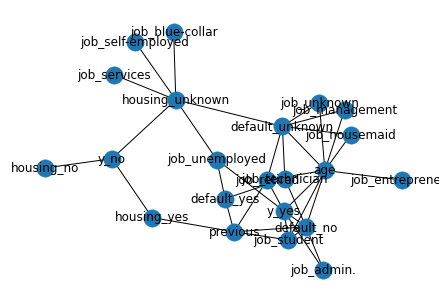

In [153]:
import networkx as nx
import matplotlib.pyplot as plt

nx.draw(graph, with_labels=True)
plt.show(graph)

# Causalnex

In [19]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')

In [20]:
df
df = df = df[["age", "job", "default", "housing", "previous", "y"]]

In [21]:
df = pd.get_dummies(df)

In [29]:
df

,age,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,y_no,y_yes
0,36,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,29,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,30,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,27,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,33,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,28,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
28827,57,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
28828,39,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
28829,46,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [28]:
import numpy as np
target_column = "y_yes"
X, y = df.drop(target_column, axis=1), df[target_column]
X = X.drop(["y_no"], axis=1)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y, name=target_column)
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X.columns).sort_values(ascending=False))


/Users/kota.misaki/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kota.misaki/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

MEAN Score: 0.889
MEAN EFFECT DIRECTIONAL CLASS 0:
job_student          0.866463
previous             0.851587
job_retired          0.557313
job_unemployed       0.109879
age                  0.007945
default_yes         -0.011307
job_unknown         -0.067197
job_admin.          -0.112607
job_housemaid       -0.253974
job_technician      -0.275611
job_self-employed   -0.281421
job_management      -0.302771
default_no          -0.320953
housing_yes         -0.425472
job_services        -0.494557
housing_unknown     -0.503017
housing_no          -0.515368
job_entrepreneur    -0.580366
job_blue-collar     -0.609007
default_unknown     -1.111596
dtype: float64


/Users/kota.misaki/.pyenv/versions/3.8.12/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
target_column = "y_yes"
X, y = df.drop(target_column, axis=1), df[target_column]
X = X.drop(["y_no"], axis=1)
from causalnex.structure import DAGClassifier
clf = DAGClassifier(
    alpha=0.1,
    beta=0.9,
    hidden_layer_units=[5],
    fit_intercept=True,
    standardize=True
)

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
scores = cross_val_score(clf, X, y, cv=KFold(shuffle=True, random_state=42))
print(f'MEAN Score: {np.mean(scores).mean():.3f}')

X = pd.DataFrame(X, columns=X.columns)
y = pd.Series(y, name=target_column)
clf.fit(X, y)
for i in range(clf.coef_.shape[0]):
    print(f"MEAN EFFECT DIRECTIONAL CLASS {i}:")
    print(pd.Series(clf.coef_[i, :], index=X.columns).sort_values(ascending=False))

MEAN Score: 0.889
MEAN EFFECT DIRECTIONAL CLASS 0:
previous             0.317404
default_no           0.142822
job_student          0.121760
job_retired          0.095232
age                  0.084056
job_admin.           0.052079
job_unemployed       0.038009
housing_yes          0.010838
job_unknown          0.003599
job_technician       0.000693
job_housemaid        0.000190
housing_unknown     -0.000001
default_yes         -0.000960
job_self-employed   -0.001348
job_management      -0.004135
housing_no          -0.020518
job_entrepreneur    -0.047868
job_services        -0.054211
job_blue-collar     -0.137158
default_unknown     -0.139316
dtype: float64


Warning: 
            Pygraphviz not installed. Also make sure you have the system-level
            ``graphviz`` requirement installed.

            Alternatively, you can visualise your graph using the networkx.draw
            functionality:
            >>> sm = StructureModel()
            >>> fig, ax = plt.subplots()
            >>> nx.draw_circular(sm, ax=ax)
            >>> fig.show()
            

/Users/kota.misaki/.pyenv/versions/3.8.12/lib/python3.8/site-packages/pygraphviz/agraph.py:1402: RuntimeWarning: Warning: node 'age', graph '' size too small for label

  warnings.warn(b"".join(errors).decode(self.encoding), RuntimeWarning)


(<Figure size 717.84x523.44 with 1 Axes>, <AxesSubplot:>)

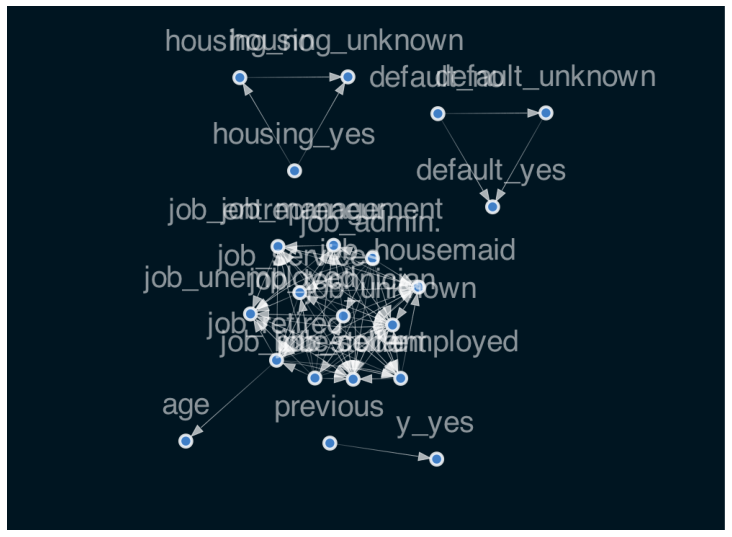

In [37]:
clf.plot_dag(True)

# cdt

In [42]:
df = df[["age", "job", "default", "housing", "previous", "y"]]
df = pd.get_dummies(df)
df.drop('y_no', axis=1)
df

,age,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_unemployed,job_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,y_no,y_yes
0,36,1,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1,29,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
2,30,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,1,0,0,1,0
3,27,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
4,33,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,28,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
28827,57,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,1,0,0,1,0
28828,39,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
28829,46,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [43]:
df = df.drop('y_no', axis=1)
df

,age,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,...,job_technician,job_unemployed,job_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,y_yes
0,36,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,29,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
2,30,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
3,27,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
4,33,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,28,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28827,57,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
28828,39,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
28829,46,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [44]:
import cdt
import networkx as nx
import matplotlib.pyplot as plt

## Get skeleton using graph Lasso

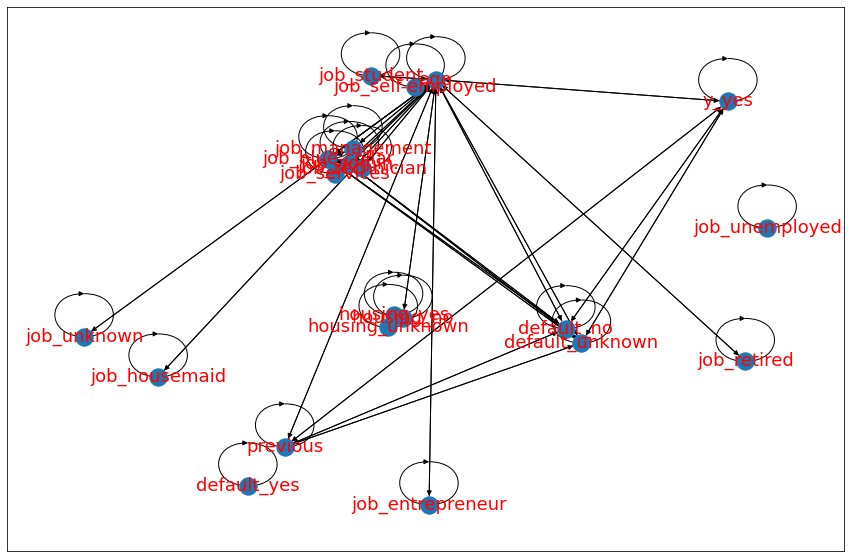

In [45]:
# intialize graph lasso
glasso = cdt.independence.graph.Glasso()

# apply graph lasso to dataset
skeleton = glasso.predict(df)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(skeleton, font_size=18, font_color='r')

### R setting

In [72]:
%load_ext rpy2.ipython

In [197]:
cdt.utils.R.DefaultRPackages.check_R_package(pcalg)

NameError: name 'pcalg' is not defined

In [76]:
%%R
library(devtools)
install_github("Diviyan-Kalainathan/RCIT", force = TRUE)

* checking for file ‘/private/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T/RtmpcVtPOY/remotes5893fa813db/Diviyan-Kalainathan-RCIT-c97f91c/DESCRIPTION’ ... OK
* preparing ‘RCIT’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘RCIT_0.1.0.tar.gz’



* installing *source* package ‘RCIT’ ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RCIT)


In [80]:
%%R
install.packages("pcalg", repos="http://R-Forge.R-project.org")




   URL 'http://R-Forge.R-project.org/bin/macosx/contrib/4.1/PACKAGES' を開けません 

  でコンパイルの必要があるかもしれません : ‘colorspace’ ‘robustbase’
  ‘bdsmatrix’ ‘RcppArmadillo’ ‘pcalg’



Do you want to attempt to install these from sources? (Yes/no/cancel) yes














* installing *source* package ‘DEoptimR’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (DEoptimR)
* installing *source* package ‘colorspace’ ...
** using staged installation
** libs


clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c colorspace.c -o colorspace.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c init.c -o init.o
clang -mmacosx-version-min=10.13 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -L/Library/Frameworks/R.framework/Resources/lib -L/usr/local/lib -o colorspace.so colorspace.o init.o -F/Library/Frameworks/R.framework/.. -framework R -Wl,-framework -Wl,CoreFoundation


installing to /Library/Frameworks/R.framework/Versions/4.1/Resources/library/00LOCK-colorspace/00new/colorspace/libs
** R
** data
*** moving datasets to lazyload DB
** demo
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (colorspace)
* installing *source* package ‘abind’ ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record o

clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c R_init_bdsmatrix.c -o R_init_bdsmatrix.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c bdsmatrix_index1.c -o bdsmatrix_index1.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c bdsmatrix_index2.c -o bdsmatrix_index2.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c bdsmatrix_index3.c -o bdsmatrix_index3.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c bdsmatrix_prod.c -o bdsmatrix_prod.o
clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resour

installing to /Library/Frameworks/R.framework/Versions/4.1/Resources/library/00LOCK-bdsmatrix/00new/bdsmatrix/libs
** R
** inst
** byte-compile and prepare package for lazy loading


Creating a generic function for ‘diag’ from package ‘base’ in package ‘bdsmatrix’
Creating a generic function for ‘diag<-’ from package ‘base’ in package ‘bdsmatrix’
Creating a new generic function for ‘backsolve’ in package ‘bdsmatrix’


** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (bdsmatrix)
* installing *source* package ‘RcppArmadillo’ ...
** using staged installation
** libs


clang++ -mmacosx-version-min=10.13 -std=gnu++14 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG  -I'/Library/Frameworks/R.framework/Versions/4.1/Resources/library/Rcpp/include' -I/usr/local/include  -I../inst/include -fPIC  -Wall -g -O2  -c RcppArmadillo.cpp -o RcppArmadillo.o
clang++ -mmacosx-version-min=10.13 -std=gnu++14 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG  -I'/Library/Frameworks/R.framework/Versions/4.1/Resources/library/Rcpp/include' -I/usr/local/include  -I../inst/include -fPIC  -Wall -g -O2  -c fastLm.cpp -o fastLm.o
clang++ -mmacosx-version-min=10.13 -std=gnu++14 -dynamiclib -Wl,-headerpad_max_install_names -undefined dynamic_lookup -single_module -multiply_defined suppress -L/Library/Frameworks/R.framework/Resources/lib -L/usr/local/lib -o RcppArmadillo.so RcppArmadillo.o fastLm.o -L/Library/Frameworks/R.framework/Resources/lib -lRlapack -L/Library/Frameworks/R.framework/Resources/lib -lRblas -L/usr/local/gfortran/lib/gcc/x86_64-apple-

ld: warning: directory not found for option '-L/usr/local/gfortran/lib/gcc/x86_64-apple-darwin18/8.2.0'
ld: warning: directory not found for option '-L/usr/local/gfortran/lib'
ld: library not found for -lgfortran
clang: error: linker command failed with exit code 1 (use -v to see invocation)
make: *** [RcppArmadillo.so] Error 1
ERROR: compilation failed for package ‘RcppArmadillo’
* removing ‘/Library/Frameworks/R.framework/Versions/4.1/Resources/library/RcppArmadillo’
* installing *source* package ‘BH’ ...
** using staged installation
** inst
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (BH)
* installing *source* package ‘robustbase’ ...
** using staged installation
** libs
make: gfortran: No such file or directory
make: *** [eigen.o] Error 1
ERROR:

clang -mmacosx-version-min=10.13 -I"/Library/Frameworks/R.framework/Resources/include" -DNDEBUG   -I/usr/local/include   -fPIC  -Wall -g -O2  -c R-rng4ftn.c -o R-rng4ftn.o
gfortran -mmacosx-version-min=10.13 -fno-optimize-sibling-calls  -fPIC  -Wall -g -O2  -c eigen.f -o eigen.o


ERROR: dependency ‘lmtest’ is not available for package ‘vcd’
* removing ‘/Library/Frameworks/R.framework/Versions/4.1/Resources/library/vcd’
ERROR: dependencies ‘graph’, ‘RBGL’, ‘igraph’, ‘ggm’, ‘corpcor’, ‘robustbase’, ‘vcd’, ‘sfsmisc’, ‘fastICA’, ‘clue’, ‘RcppArmadillo’ are not available for package ‘pcalg’
* removing ‘/Library/Frameworks/R.framework/Versions/4.1/Resources/library/pcalg’

	‘/private/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T/RtmpcVtPOY/downloaded_packages’



In [184]:
%%R
install.packages("RCIT", dependencies=TRUE)
install.packages("pcalg", dependencies=TRUE)
install.packages("kpcalg", dependencies=TRUE)
install.packages("bnlearn", dependencies=TRUE)
install.packages("sparsebn", dependencies=TRUE)
install.packages("SID", dependencies=TRUE)
install.packages("CAM", dependencies=TRUE)
install.packages("D2C", dependencies=TRUE)
install.packages("graph", dependencies=TRUE)
install.packages("RGBL", dependencies=TRUE)
install.packages("Rgraphviz", dependencies=TRUE)
install.packages("CAM", dependencies=TRUE)


The downloaded binary packages are in
	/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T//RtmpcVtPOY/downloaded_packages



The downloaded binary packages are in
	/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T//RtmpcVtPOY/downloaded_packages



The downloaded binary packages are in
	/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T//RtmpcVtPOY/downloaded_packages



The downloaded binary packages are in
	/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T//RtmpcVtPOY/downloaded_packages



The downloaded binary packages are in
	/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T//RtmpcVtPOY/downloaded_packages


In [167]:
%%R
library(devtools)
install_github("ericstrobl/RCIT")
library(RCIT)
RCIT(rnorm(1000),rnorm(1000),rnorm(1000))
RCoT(rnorm(1000),rnorm(1000),rnorm(1000))
RCoT(rnorm(1000),rnorm(1000),matrix(rnorm(2000),1000,2))



* checking for file ‘/private/var/folders/hr/nx34779d0vn52t6jyrjxq0gr0000gn/T/RtmpcVtPOY/remotes589577ae583/ericstrobl-RCIT-7a7fb2b/DESCRIPTION’ ... OK
* preparing ‘RCIT’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘RCIT_0.1.0.tar.gz’



* installing *source* package ‘RCIT’ ...
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (RCIT)



	Approximate Kernel-based Conditional Independence

data:  RCIT
= 31.223, p-value = 0.2276
sample estimates:
[1] 31.22274



In [154]:
from rpy2.robjects.packages import importr
importr('graph')
# importr('RGBL')
importr('RCIT')
importr("pcalg")
importr('kpcalg')

rpy2.robjects.packages.Package as a <module 'kpcalg'>

In [161]:
%%R
library("RCIT")
library("pcalg")
library("kpcalg")

### FSGNN

train
predict
--- Execution time : 531. seconds ---


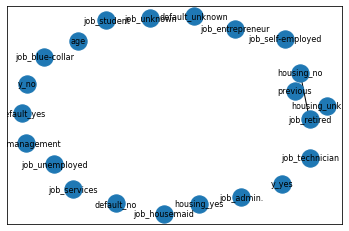

,0,1,2
0,job_retired,housing_no,0.012506


In [206]:
import cdt
from cdt import SETTINGS
SETTINGS.verbose=False
SETTINGS.NJOBS=16
import networkx as nx
import time
# A warning on R libraries might occur. It is for the use of the r libraries that could be imported into the framework
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
# Finding the structure of the graph
from cdt.independence.graph import FSGNN

Fsgnn = FSGNN(train_epochs=5, test_epochs=3, l1=0.1, batch_size=1000)
print("train")
start_time = time.time()
print("predict")
ugraph = Fsgnn.predict(df[:5001], threshold=1e-2)

print("--- Execution time : %4.4s seconds ---" % (time.time() - start_time))
nx.draw_networkx(ugraph, font_size=8) # The plot function allows for quick visualization of the graph.
plt.show()
# List results
pd.DataFrame(list(ugraph.edges(data='weight')))

### SAM

100%|█| 4000/4000 [21:59<00:00,  3.03it/s, disc=-.577, gen=-1.02, regul_loss=1.2
100%|█| 4000/4000 [29:00<00:00,  2.30it/s, disc=-.465, gen=-1.06, regul_loss=0.8
100%|█| 4000/4000 [29:28<00:00,  2.26it/s, disc=1.87, gen=-.751, regul_loss=0.50
100%|█| 4000/4000 [23:06<00:00,  2.88it/s, disc=-1.44, gen=-.859, regul_loss=0.5
100%|█| 4000/4000 [27:06<00:00,  2.46it/s, disc=-.647, gen=-1, regul_loss=0.68, 
100%|█| 4000/4000 [25:56<00:00,  2.57it/s, disc=-1.72, gen=-.921, regul_loss=0.7
100%|█| 4000/4000 [19:35<00:00,  3.40it/s, disc=-2.05, gen=-.777, regul_loss=0.7
100%|█| 4000/4000 [19:46<00:00,  3.37it/s, disc=-2.11, gen=-1.02, regul_loss=0.5


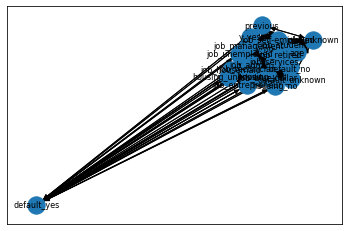

In [208]:
import networkx as nx
from cdt.causality.graph import SAM
from cdt.data import load_dataset
# data, graph = load_dataset("sachs")
obj = SAM()
#The predict() method works without a graph, or with a
#directed or undirected graph provided as an input
output = obj.predict(df[:500])    #No graph provided as an argument
#To view the graph created, run the below commands:
nx.draw_networkx(output, font_size=8)
plt.show()

### CGNN

In [181]:
import networkx as nx
from cdt.causality.graph import CGNN
from cdt.data import load_dataset
# data, graph = load_dataset("sachs")
obj = CGNN()
#The predict() method works without a graph, or with a
#directed or undirected graph provided as an input
output = obj.predict(df)    #No graph provided as an argument


#To view the graph created, run the below commands:
nx.draw_networkx(output, font_size=8)
plt.show()

An exhaustive search of the causal structure of CGNN without skeleton is super-exponential in the number of variables.


KeyboardInterrupt: 

### CCDr

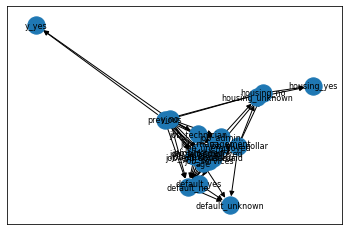

In [182]:
import networkx as nx
from cdt.causality.graph import CCDr
from cdt.data import load_dataset
# data, graph = load_dataset("sachs")
obj = CCDr()
#The predict() method works without a graph, or with a
#directed or undirected graph provided as an input
output = obj.predict(df)    #No graph provided as an argument


#To view the graph created, run the below commands:
nx.draw_networkx(output, font_size=8)
plt.show()

### PC

PC is ran on the skeleton of the given graph.


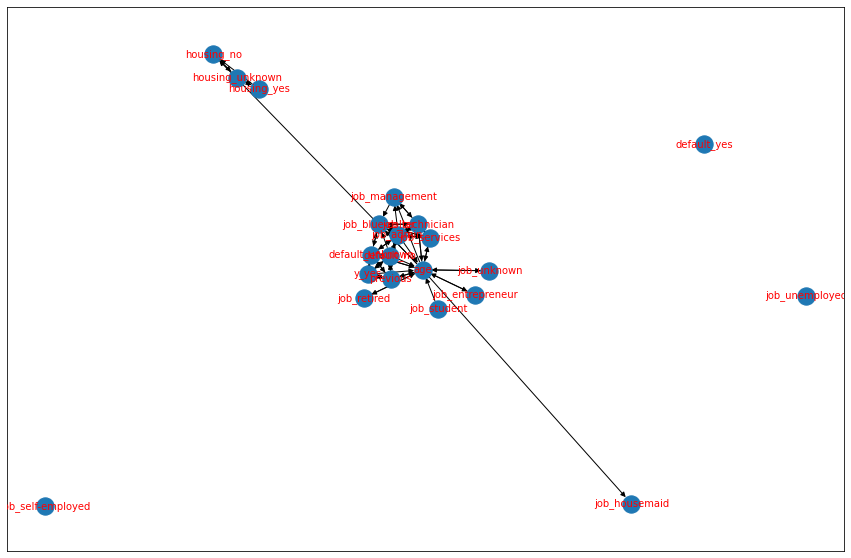

In [46]:
import cdt
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from cdt.causality.graph import PC

model_pc = cdt.causality.graph.PC()
# graph_pc = model_pc.predict(df)
graph_pc = model_pc.predict(df, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_pc, font_size=10, font_color='r')

# get adjaceny matrix of PC graph
A_pc = nx.adjacency_matrix(graph_pc).todense()

### GES

GES is ran on the skeleton of the given graph.


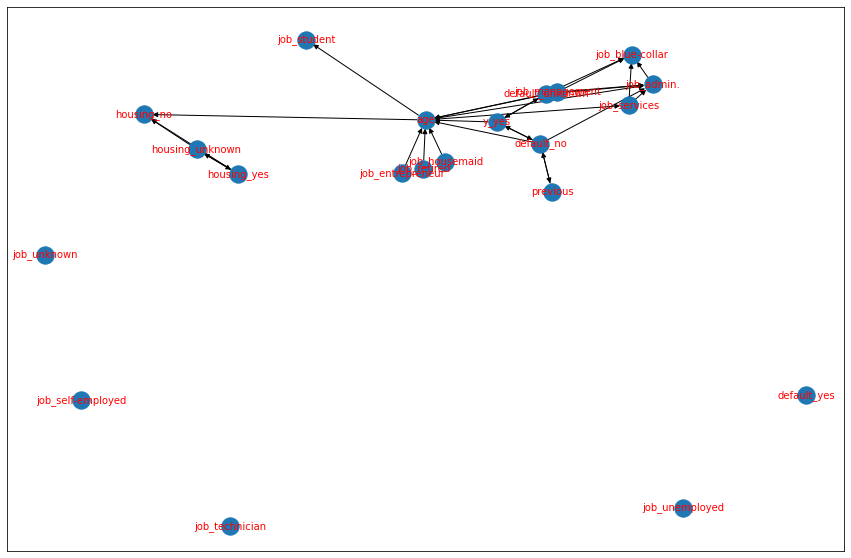

convert marital from object to categorical
convert month from object to categorical
convert previous from int64 to <class 'numpy.uint8'>
convert cons_price_idx from float64 to <class 'numpy.float32'>
convert age from int64 to <class 'numpy.uint8'>
convert default from object to categorical
convert housing from object to categorical
convert contact from object to categorical
convert day_of_week from object to categorical
convert emp_var_rate from float64 to <class 'numpy.float32'>
convert cons_conf_idx from float64 to <class 'numpy.float32'>
convert nr_employed from float64 to <class 'numpy.float32'>
convert education from object to categorical
convert y from object to categorical
convert job from object to categorical
convert loan from object to categorical
convert duration from int64 to <class 'numpy.uint16'>
convert campaign from int64 to <class 'numpy.uint8'>
convert pdays from int64 to <class 'numpy.uint16'>
convert poutcome from object to categorical
convert euribor3m from float64

In [47]:
model_ges = cdt.causality.graph.GES()
# apply causal discovery model to data and skeleton
graph_ges = model_ges.predict(df, skeleton)

# visualize network
fig=plt.figure(figsize=(15,10))
nx.draw_networkx(graph_ges, font_size=10, font_color='r')

# get adjaceny matrix of GES graph
A_ges = nx.adjacency_matrix(graph_ges).todense()

## Demonstration of XAI using causalnex

In [49]:
!pip install wget
import wget
# Download cancer dataset: http://archive.ics.uci.edu/ml/datasets/Breast+Cancer
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer/breast-cancer.data"
wget.download(url, '')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=077bb3f6aa5a729b2fa342ed763d184550c9fc4b8e3146bcc8c168b253816022
  Stored in directory: /Users/kota.misaki/Library/Caches/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget
100% [..........................................................] 18654 / 18654

'breast-cancer.data'

In [51]:
import pandas as pd
import numpy as np
colnames = ['events', 'ages', 'menopause', 'tumor-size', 'inv-nodes', 
           'node-carps', 'deg-malig', 
           'breast', 'beast-quad', 'irradiat']
df = pd.read_csv("breast-cancer.data", names = colnames, header=None)
df_select = df[['ages', 'irradiat', 'menopause', 'breast', 'events']]
df.head()

,events,ages,menopause,tumor-size,inv-nodes,node-carps,deg-malig,breast,beast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


array([<AxesSubplot:title={'center':'events_irradiat'}>], dtype=object)

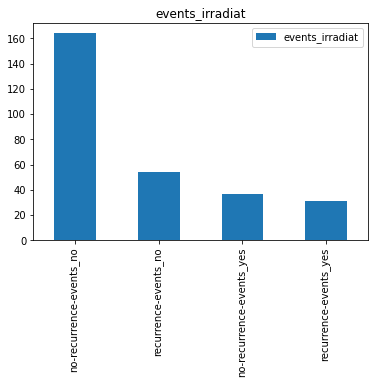

In [52]:
df['events_irradiat'] = df['events'] + '_' + df['irradiat']
df[['events_irradiat']].apply(pd.value_counts).plot(kind = 'bar', subplots = True)

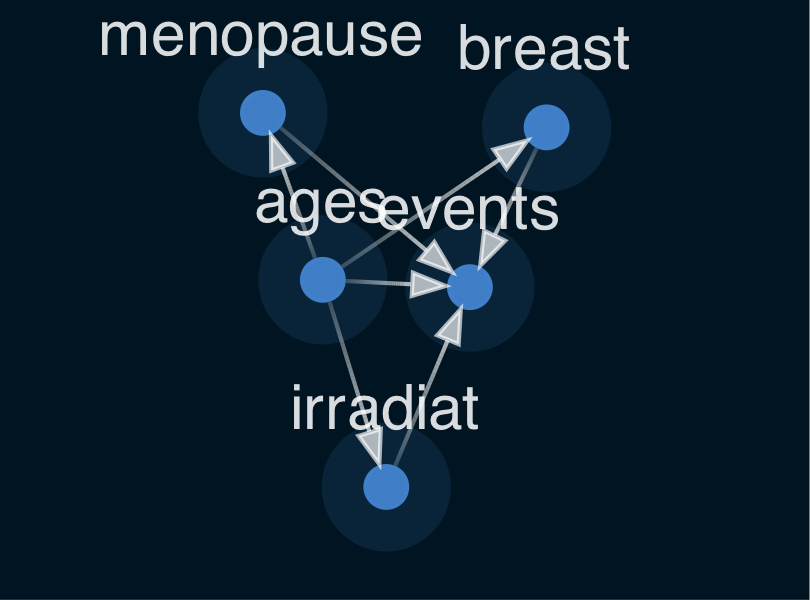

In [57]:
from causalnex.structure import StructureModel
from causalnex.plots import plot_structure
from IPython.display import Image
sm_cancer_true = StructureModel()
  
sm_cancer_true.add_edges_from([
   ('ages', 'events'),
   ('ages', 'irradiat'),
   ('irradiat', 'events'),
   ('ages', 'menopause'),
   ('menopause', 'events'),
   ('ages', 'breast'),
   ('breast', 'events'),
])
  
viz = plot_structure(
   sm_cancer_true,
   graph_attributes={"scale": "0.7"},
#    all_node_attributes=NODE_STYLE.WEAK,
#    all_edge_attributes=EDGE_STYLE.WEAK,
)
Image(viz.draw(format='png'))

In [58]:
from sklearn.model_selection import train_test_split
from causalnex.network import BayesianNetwork
from causalnex.evaluation import roc_auc
  
# seperate train/test data
train, test = train_test_split(df_select, train_size=0.8, random_state=42)
  
# generate BayesianNetwork
bn_true = BayesianNetwork(sm_cancer_true)
print("sm_cancer_true: ", sm_cancer_true)
print("bn_true: ", bn_true)
  
# fit the model with train data
bn_true = bn_true.fit_node_states(df_select)
bn_true = bn_true.fit_cpds(train, method="BayesianEstimator", bayes_prior="K2")
  
# test the model using test data
roc, auc = roc_auc(bn_true, test, "events")
print("\nAUC: {}".format(auc))
print("\nConditional Probability Distributions (CPDs):\n{}".format(bn_true.cpds['irradiat']))

sm_cancer_true:  StructureModel with 5 nodes and 7 edges
bn_true:  <causalnex.network.network.BayesianNetwork object at 0x14a4f0670>

AUC: 0.6755350772889417

Conditional Probability Distributions (CPDs):
ages     20-29     30-39     40-49    50-59     60-69     70-79
irradiat                                                       
no         0.5  0.655172  0.727273  0.82716  0.772727  0.857143
yes        0.5  0.344828  0.272727  0.17284  0.227273  0.142857


BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.


In [66]:
from causalnex.inference import InferenceEngine

def compute_irradiat_cf_and_effect(bn):
    ie = InferenceEngine(bn)
    ie.do_intervention("irradiat", {'yes': 0.0, 'no': 1.0})
    events_no = pd.Series(ie.query()["events"])
    ie.do_intervention("irradiat", {'yes': 1.0, 'no': 0.0})
    events_yes = pd.Series(ie.query()["events"])
  
    cf = pd.concat([events_no, events_yes], axis=1)  
    cf.rename(columns={0:"events_no", 1:"events_yes"}, inplace=True)

    cf["avg"] = (cf["events_no"] + cf["events_yes"])/2.0
    expected_no = cf["avg"]["no-recurrence-events"]
    expected_yes = cf["avg"]["recurrence-events"]
    effect = expected_yes / expected_no
    print("\nEffect: {}\n".format(effect))
    return cf
  
counterfactuals = compute_irradiat_cf_and_effect(bn_true)
counterfactuals


Effect: 0.5980045954063495



,events_no,events_yes,avg
no-recurrence-events,0.713594,0.537967,0.62578
recurrence-events,0.286406,0.462033,0.37422


# Causalml
## may not be appropriate because this algorithm requires interventional data

In [2]:
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor
from causalml.inference.meta import BaseRRegressor
from xgboost import XGBRegressor
from causalml.dataset import synthetic_data

y, X, treatment, _, _, e = synthetic_data(mode=1, n=1000, p=5, sigma=1.0)

lr = LRSRegressor()
te, lb, ub = lr.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Linear Regression): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X, treatment, y)
print('Average Treatment Effect (XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

nn = MLPTRegressor(hidden_layer_sizes=(10, 10),
                 learning_rate_init=.1,
                 early_stopping=True,
                 random_state=42)
te, lb, ub = nn.estimate_ate(X, treatment, y)
print('Average Treatment Effect (Neural Network (MLP)): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

xl = BaseXRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub = xl.estimate_ate(X, treatment, y, e)
print('Average Treatment Effect (BaseXRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

rl = BaseRRegressor(learner=XGBRegressor(random_state=42))
te, lb, ub =  rl.estimate_ate(X=X, p=e, treatment=treatment, y=y)
print('Average Treatment Effect (BaseRRegressor using XGBoost): {:.2f} ({:.2f}, {:.2f})'.format(te[0], lb[0], ub[0]))

sklearn.tree._tree.TreeBuilder size changed, may indicate binary incompatibility. Expected 72 from C header, got 80 from PyObject


Average Treatment Effect (Linear Regression): 0.67 (0.52, 0.82)
Average Treatment Effect (XGBoost): 0.46 (0.39, 0.54)
Average Treatment Effect (Neural Network (MLP)): 0.94 (0.81, 1.07)
Average Treatment Effect (BaseXRegressor using XGBoost): 0.41 (0.36, 0.46)
Average Treatment Effect (BaseRRegressor using XGBoost): 0.53 (0.53, 0.54)
